In [6]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import optuna

In [192]:
# CNN для обработки изображения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(ActorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*(n_observations - 4)*(n_observations - 4), 256)
        self.fc2 = nn.Linear(256, n_actions)


    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32*92*92)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CriticNet(nn.Module):
    def __init__(self, n_observations):
        super(CriticNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*(n_observations - 4)*(n_observations - 4), 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32*92*92)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


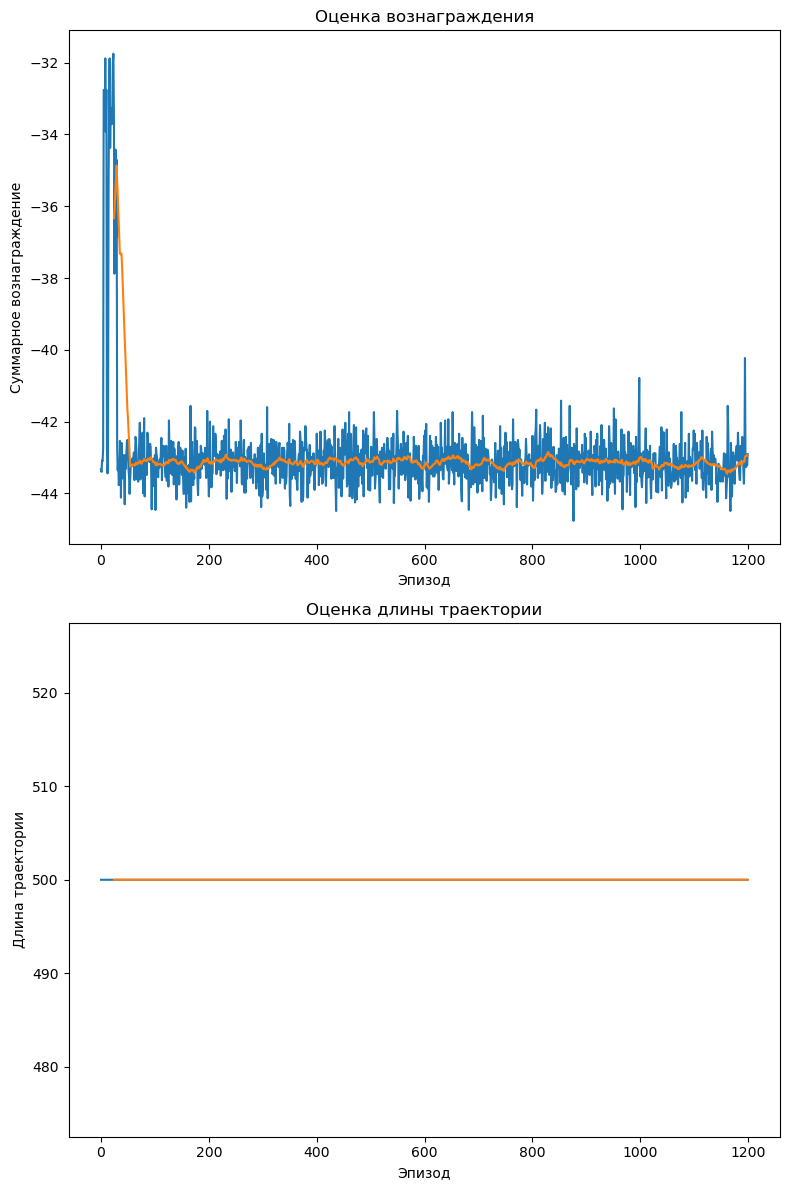

In [199]:
# Агент для метода A2C
class A2CAgent:
    # Конструктор 
    def __init__(self, env, 
                 LR=0.001, DF=0.99, DEVICE='cpu', HDIM=16):
        # Среда
        self.env = env
        # Скорость обучения
        self.learning_rate = LR
        # Величина дисконтирования
        self.discount_factor = DF
        # Выбор размещения нейронных сетей
        self.device = DEVICE
        # Определяем нейронные сети целевую и политики
        # Первый параметр определяет количество наблюдений, второе число действий
        self.actor = ActorNet(96, 3).to(self.device)
        self.critic = CriticNet(96).to(self.device)
        # self.actor = ActorNet(len(self.env.reset()[0].reshape(-1)), self.env.action_space.n, HDIM).to(self.device)
        # self.critic = CriticNet(len(self.env.reset()[0].reshape(-1)), HDIM).to(self.device)
        # Задаём оптимайзер для нейронной сети
        self.actor_optimizer = optim.AdamW(self.actor.parameters(), lr=self.learning_rate)
        self.critic_optimizer = optim.AdamW(self.actor.parameters(), lr=self.learning_rate)
        # Длины траекторий по эпизодам
        self.steps = []
        # Итоговое вознаграждение по эпизодам
        self.rewards = []

    # Перевод в тензор
    def __totensor(self, x, tensortype=torch.float):
        return torch.tensor(x, dtype=tensortype).to(self.device)
    
    # Оценка действия сетью Actor
    def __get_action(self, state):
        with torch.no_grad():
            state_batch = self.__totensor(np.expand_dims(state, axis=0))
            actions = self.actor(state_batch).squeeze(dim=0)
            return actions.tolist()
    
    # Проигрываем эпизод 
    def __play_episode(self, STEP_LIMIT=50):
        # Длина траектории
        steps = 0
        # Состояния, действия и вознаграждения по текущему эпизоду
        states, actions, rewards = [], [], []
        # Начальное состояние окружения
        done = False
        state, _ = self.env.reset()
        # Проход по траектории
        while (not done) & (steps<STEP_LIMIT):
            # Сохраняем состояние
            states.append(state.tolist())
            # Получили действие от сети Actor
            action = self.__get_action(state)
            # Делаем следующий шаг
            state, reward, terminated, truncated, _ = self.env.step(action)
            # Объединяем done по двум конечным состояниям
            done = terminated or truncated
            # Сохраняем действие и вознаграждение
            actions.append(action)
            rewards.append(reward)
            # Шаг вперёд
            steps += 1
        
        # Сохраняем длину траектории
        self.steps.append(steps)
        # Сохраняем вознаграждение за эпизод            
        self.rewards.append(sum(rewards))
        # Расчитываем накопленное вознаграждение с учётом дисконтирования
        cum_rewards = np.zeros_like(rewards)
        discounted_reward = 0
        for t in reversed(range(len(rewards))):
            discounted_reward = rewards[t] + discounted_reward * self.discount_factor
            cum_rewards[t] = discounted_reward
        
        return states, actions, rewards, cum_rewards

    # Обучение Агента
    def train(self, num_episodes=50, logfreq=20):
        # Обнуляем прошлый опыт
        self.rewards, self.steps = [], []
        for episode in range(num_episodes):
            # Проигрываем эпизод с ограничением по длине траектории
            states, actions, rewards, cum_rewards = self.__play_episode(500)
            # Обновляем веса сети Critic
            self.critic_optimizer.zero_grad()
            states = self.__totensor(states)
            cum_rewards = self.__totensor(cum_rewards)
            values = self.critic(states).squeeze(dim=1)
            critic_loss = F.mse_loss(values, cum_rewards)
            critic_loss.sum().backward()
            self.critic_optimizer.step()
            # Обновляем веса сети Actor
            with torch.no_grad():
                values = self.critic(states)
            self.actor_optimizer.zero_grad()
            advantages = cum_rewards - values
            # Расчёт вероятности действий
            actions_mean = self.actor(states)
            m = torch.distributions.MultivariateNormal(actions_mean.cpu(), torch.eye(3))
            log_probs = m.log_prob(m.sample())
            actor_loss = -log_probs.to(self.device) * advantages
            # Обратный проход и шаг оптимизатора
            actor_loss.sum().backward()
            self.actor_optimizer.step()
            # Выводим результаты с заданной частотой
            if (episode + 1)%logfreq == 0:
                print(f"Run episode {episode+1} with average reward {np.mean(self.rewards[-logfreq:]):.2f}", end="\r")

    def plot_rewards(self, window_size=10):
        # Сгладим графики
        smoothed_rewards = pd.Series(self.rewards).rolling(window_size, min_periods=window_size).mean()
        smoothed_steps = pd.Series(self.steps).rolling(window_size, min_periods=window_size).mean()

        plt.figure(figsize=(8, 12))
        plt.subplot(2, 1, 1)
        plt.plot(self.rewards)
        plt.plot(smoothed_rewards)
        plt.xlabel('Эпизод')
        plt.ylabel('Суммарное вознаграждение')
        plt.title('Оценка вознаграждения')

        plt.subplot(2, 1, 2)
        plt.plot(self.steps)
        plt.plot(smoothed_steps)
        plt.xlabel('Эпизод')
        plt.ylabel('Длина траектории')
        plt.title('Оценка длины траектории')

        plt.tight_layout()
        plt.show()

agent = A2CAgent(gym.make("CarRacing-v2"),# continuous=False), 
                  LR=1E-3, DEVICE="mps")
agent.train(num_episodes=1200, logfreq=5)
agent.plot_rewards(25)

In [67]:
# env_names = [env for env in gym.envs.registry]

# # Выводим список названий сред
# for env_name in env_names:
#     print(env_name)

In [ ]:
# testEnv = gym.make("CarRacing-v2")
# action = testEnv.action_space.sample()
# action

In [ ]:
# agent = A2CAgent(gym.make("CarRacing-v2"),# continuous=False), 
#                   LR=1E-3, DEVICE="mps")
# agent.train(num_episodes=500, logfreq=5)
# agent.plot_rewards(25)